作者: 阿凯爱玩机器人 | 微信: xingshunkai  | QQ: 244561792

[B站](https://space.bilibili.com/40344504) | [淘宝店铺](https://shop140985627.taobao.com) | [购买链接](https://item.taobao.com/item.htm?id=677075846402)

## 导入依赖

In [1]:
import time
import numpy as np
import cv2
from matplotlib import pyplot as plt
# 阿凯机器人工具箱
# - Gemini335类
from kyle_robot_toolbox.camera import Gemini335
# - 色块识别
from kyle_robot_toolbox.opencv import detect_color_block

%matplotlib inline

pybullet build time: Jun  3 2022 02:05:55


## 相机与检测器初始化

In [2]:
# 创建相机对象
camera = Gemini335()

[ WARN:0@3.898] global obsensor_stream_channel_v4l2.cpp:82 xioctl ioctl: fd=60, req=-1060088315
[ WARN:0@3.898] global obsensor_stream_channel_v4l2.cpp:219 start ioctl error return: 16
[ WARN:0@3.898] global obsensor_stream_channel_v4l2.cpp:82 xioctl ioctl: fd=62, req=-1060088315
[ WARN:0@3.898] global obsensor_stream_channel_v4l2.cpp:219 start ioctl error return: 16


## 读入HSV颜色阈值

In [3]:
# 载入HSV阈值
hsv_lowerb = np.load("config/hsv_range/red_hsv_lowerb.npy")
hsv_upperb = np.load("config/hsv_range/red_hsv_upperb.npy")

## 采集图像

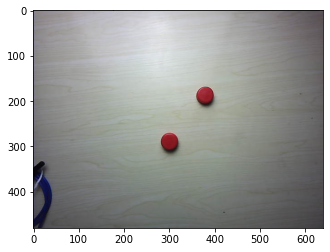

In [4]:
# 采集图像
img_bgr = camera.read_color_img()
# 图像可视化
plt.imshow(img_bgr[:, :, ::-1])

In [5]:
# cv2.imwrite("img_bgr.png", img_bgr)

True

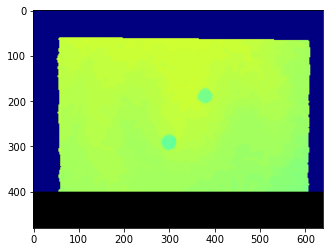

In [6]:
# 采集深度图, 单位为mm
# 数据格式为np.float32
depth_img = camera.read_depth_img() 

# 将深度转换为可视化画布
# 根据实际情况调整深度范围 [min_distance, max_distance]
depth_canvas_tmp = camera.depth_img2canvas(depth_img, min_distance=300, \
                                    max_distance=450)
# 为了兼容Gemini深度图与彩图尺寸不一致的情况
# 要做一下特殊处理
dp_h, dp_w, dp_ch = depth_canvas_tmp.shape
depth_canvas = np.zeros_like(img_bgr)
depth_canvas[:dp_h, :dp_w] = depth_canvas_tmp

plt.imshow(depth_canvas[:, :, ::-1])

In [7]:
# cv2.imwrite("depth_canvas.png", depth_canvas)

True

## 检测色块

ROI矩形区域列表[x, y, w, h]:
 [(282, 268, 41, 44), (361, 167, 39, 43)]


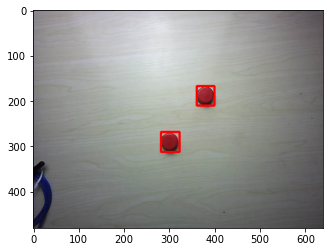

In [18]:
# 色块检测
rect_list, mask, canvas = detect_color_block(img_bgr, hsv_lowerb, hsv_upperb)
print(f"ROI矩形区域列表[x, y, w, h]:\n {rect_list}")
# 显示画布
plt.imshow(canvas[:, :, ::-1])

In [9]:
# cv2.imwrite("color_block_detect.png", canvas)

True

## 绘制色块中心点

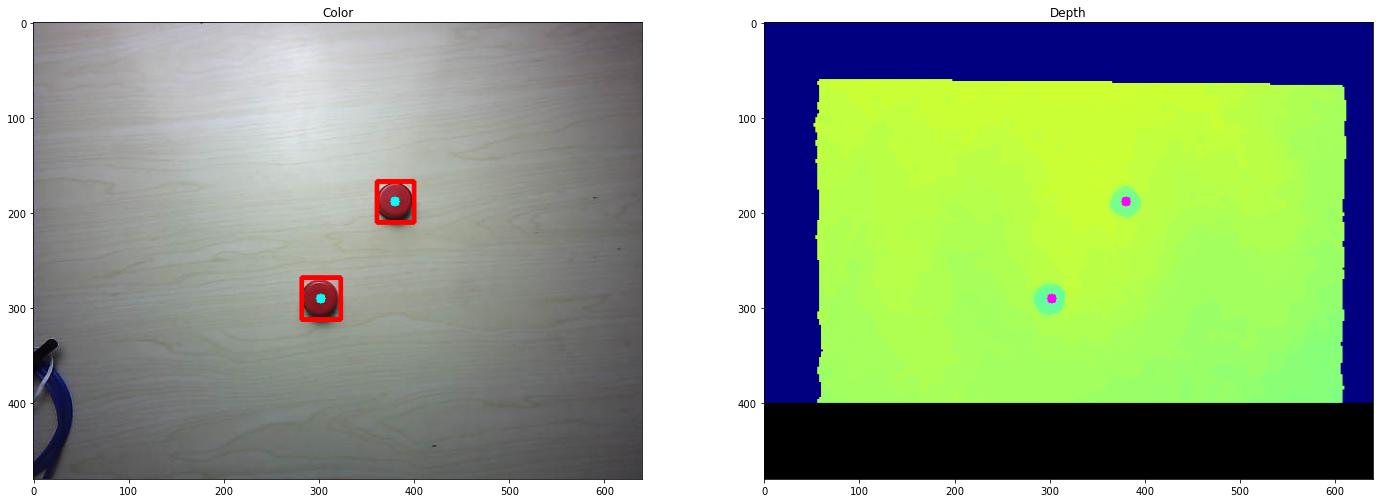

In [19]:
center_list = []

for rect in rect_list:
    # 读取矩形框
    x, y, w, h = rect
    # 计算中心点
    cx = int(x + w/2)
    cy = int(y + h/2)
    # 绘制中心点
    cv2.circle(canvas, [cx, cy], 5, (255, 255, 0), -1)
    cv2.circle(depth_canvas, [cx, cy], 5, (255, 0, 255), -1)
    center_list.append([cx, cy])
    
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.title("Color")
plt.imshow(canvas[:, :, ::-1])

plt.subplot(1, 2, 2)
plt.title("Depth")
plt.imshow(depth_canvas[:, :, ::-1])

# plt.savefig("canvas_depth.png")

## 获取物块中心点的三维坐标

深度值: 372.0 mm
彩色相机坐标系下的坐标: [-22.1, 38.3, 372.0], 单位mm
深度值: 374.0 mm
彩色相机坐标系下的坐标: [42.3, -45.8, 374.0], 单位mm


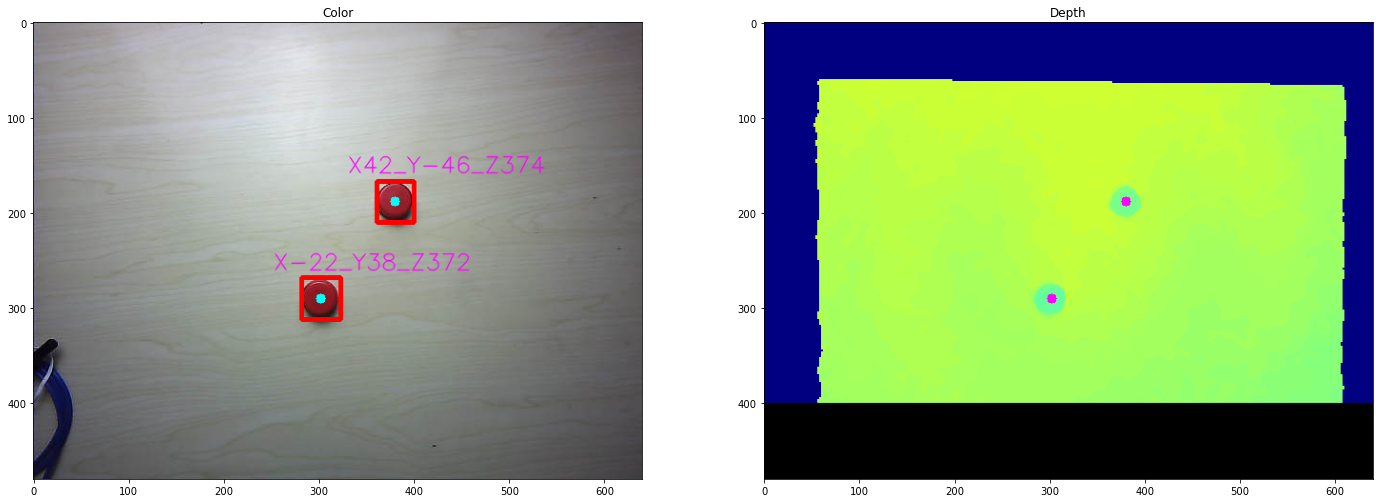

In [20]:

for center in center_list:
    px, py = center
    # 读取深度值
    depth_value = depth_img[py, px]
    print(f"深度值: {depth_value} mm")
    # 判断坐标是否在深度图的有效范围内
    if px >= dp_w or py >= dp_h:
        continue 
    # 读取深度值
    depth_value = depth_img[py, px]
    # 深度值无效
    if depth_value == 0:
        continue
            
    cam_point3d = camera.depth_pixel2cam_point3d(\
                                    px, py, depth_value=depth_value)
    # 计算三维坐标
    cam_x, cam_y, cam_z = cam_point3d
    print(f"彩色相机坐标系下的坐标: [{cam_x:.1f}, {cam_y:.1f}, {cam_z:.1f}], 单位mm")
    # 在画面上绘制坐标
    tag = f"X{cam_x:.0f}_Y{cam_y:.0f}_Z{cam_z:.0f}"
    cv2.putText(canvas, text=tag,\
        org=(px-50, py-30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, \
        fontScale=0.8, thickness=1, lineType=cv2.LINE_AA, color=(255, 0, 255))

plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.title("Color")
plt.imshow(canvas[:, :, ::-1])

plt.subplot(1, 2, 2)
plt.title("Depth")
plt.imshow(depth_canvas[:, :, ::-1])

# plt.savefig("canvas_depth2.png")